In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn as sklearn
from sklearn import linear_model, cross_validation, metrics, svm, ensemble
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.cross_validation  import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import itertools

from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import csv
%matplotlib inline

In [2]:
flights = pd.read_csv('2008.csv/2008.csv')

In [61]:
agg_df = flights.groupby(['Origin','Dest']).size().reset_index()
agg_df.columns = ["ori", "des","count"]
agg_df.ix[agg_df['count'].idxmax()]
print (agg_df.nlargest(10, 'count'))

      ori  des  count
4733  SFO  LAX  13299
2778  LAX  SFO  12935
3671  OGG  HNL  12138
2110  HNL  OGG  11779
2745  LAX  LAS  11562
2651  LAS  LAX  11508
2821  LGA  BOS  11226
585   BOS  LGA  11218
2773  LAX  SAN  11144
4501  SAN  LAX  11053


### The Atlanta airport seems to have enough records for making a prediction apart from being the most busiest airport in USA, Thus we will make a model based on the Atlanta's hartsfield jackson International Airport, where in our model will reveal the delays based on the flights flying in and out of Atlanta

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

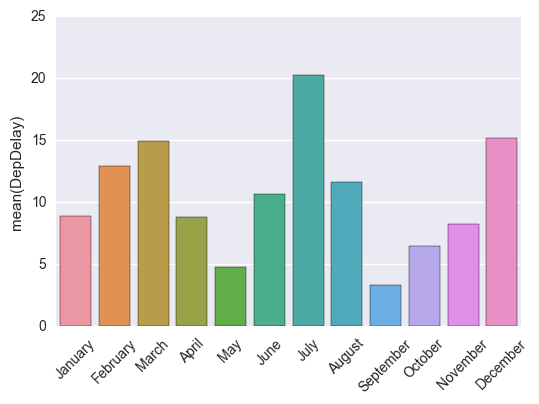

In [58]:
atlanta = flights[(flights['Dest'] == 'ATL') | (flights['Origin']=='ATL')]
import seaborn as sns
Months = np.array(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
mon = np.arange(len(Months))
ax = sns.barplot(mon, atlanta[['Month','DepDelay']].groupby('Month').mean().reset_index().DepDelay)
plt.setp(ax.axes,  xticklabels=Months)
plt.xticks(rotation=45)


In [3]:
def show_confusion_matrix(cm):
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Oranges')
    plt.colorbar()
    target_names = ['Not Delayed', 'Delayed']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
def azureMLlr(flights):
    
    min_delay = 15
    flights.dropna(subset=['CRSElapsedTime'], inplace=True)
    flights.dropna(subset=['DepDelay'], inplace=True)
    flights['CRSDepTimeinHr'] = flights['CRSDepTime']//100
    flights['CRSArrTimeinHr'] = flights['CRSArrTime']//100
    direction = 'Origin'
    col2 = 'DepDelay'
    if direction == 'Origin':
        col1 = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Dest','CRSElapsedTime','Distance']
    else:
        col1 = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Origin','CRSElapsedTime','Distance']

    X = flights[flights[direction] == 'ATL'][col1]
    Y = flights[flights[direction] == 'ATL'][col2]
    X['UniqueCarrier'] = pd.factorize(X['UniqueCarrier'])[0]

    if direction == 'Origin':
        X['Dest'] = pd.factorize(X['Dest'])[0]
    else:
        X['Origin'] = pd.factorize(X['Origin'])[0]

    random_rows = np.random.choice(X.index.values, 800000)
    random_X = X.ix[random_rows]
    random_Y = Y.ix[random_rows]

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(random_X, random_Y, test_size=0.20, random_state=0)
   
    lr = sklearn.linear_model.LogisticRegression( class_weight='auto')
    logistic_fit=lr.fit(Xtrain, np.where(Ytrain >= min_delay,1,0))
    pre = lr.predict(Xtest)

    
    conf_mat = confusion_matrix(np.where(Ytest >= min_delay,1,0), pre)
    
    No_of_actual_delays = conf_mat[1][0] + conf_mat[1][1]
    No_of_pred_delays = conf_mat[0][1] + conf_mat[1][1]
    No_of_records = conf_mat[0][1] + conf_mat[1][1] + conf_mat[1][0] + conf_mat[0][0]
    No_of_delays_properly_classified = conf_mat[1][1]
    No_of_nonDelays_improperly_classified_as_delys = conf_mat[0][1]
    
    fprate, tprate, _ = metrics.roc_curve(pre, np.where(Ytest >= min_delay,1,0))

    plt.figure()
    plt.plot(fprate,tprate,label = 'ROC curve')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('1-Sensitivity(false_positive_rate)')
    plt.ylabel('Sensitivity(true_positive_rate)')
    plt.title('ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()
    
    print('AUC(Area Under Curve): ')
    print( metrics.auc(fprate, tprate))
    
#     print(pd.DataFrame(conf_mat))
    rf_report = precision_recall_fscore_support(list(np.where(Ytest >= min_delay,1,0)), list(pre), average='micro')

    show_confusion_matrix(conf_mat)

    d = {'precision': [rf_report[0]],'recall':[rf_report[1]],'F1':[rf_report[2]],'accuracy':[ accuracy_score(list(np.where(Ytest >= min_delay,1,0)), list(pre))]
        ,'No_of_actual_delays':[No_of_actual_delays],'No_of_pred_delays': [No_of_pred_delays], 'No_of_records': [No_of_records], 'No_of_delays_properly_classified': [No_of_delays_properly_classified]
        ,'No_of_nonDelays_improperly_classified_as_delys': [No_of_nonDelays_improperly_classified_as_delys]}
    df = pd.DataFrame(data=d)
    
    return df
   

C:\Users\pruth\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


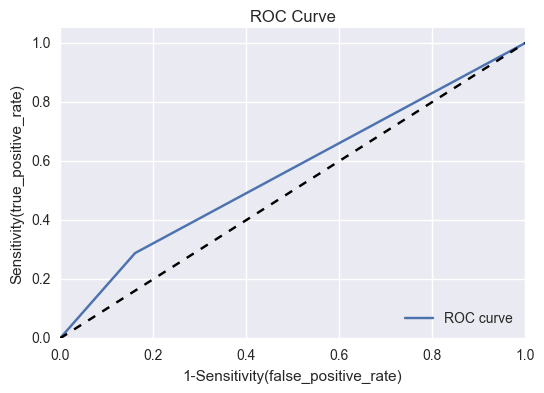

AUC(Area Under Curve): 
0.563699283474


C:\Users\pruth\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


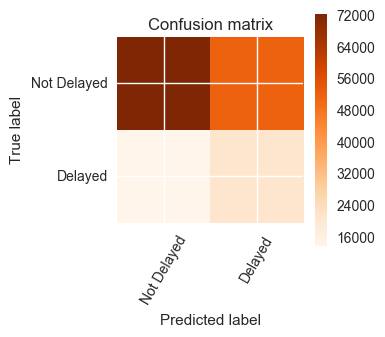

{'F1': [0.39026594371288409],
 'No_of_actual_delays': [35146],
 'No_of_delays_properly_classified': [21161],
 'No_of_nonDelays_improperly_classified_as_delys': [52137],
 'No_of_pred_delays': [73298],
 'No_of_records': [160000],
 'accuracy': [0.58673750000000002],
 'precision': [0.28869819094654697],
 'recall': [0.60208843111591648]}

In [47]:
azureMLlr(flights)

In [48]:
def azureMLrf(flights):
    
    min_delay = 15
    flights.dropna(subset=['CRSElapsedTime'], inplace=True)
    flights.dropna(subset=['DepDelay'], inplace=True)
    flights['CRSDepTimeinHr'] = flights['CRSDepTime']//100
    flights['CRSArrTimeinHr'] = flights['CRSArrTime']//100
    direction = 'Origin'
    col2 = 'DepDelay'
    if direction == 'Origin':
        col1 = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Dest','CRSElapsedTime','Distance']
    else:
        col1 = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Origin','CRSElapsedTime','Distance']

    X = flights[flights[direction] == 'ATL'][col1]
    Y = flights[flights[direction] == 'ATL'][col2]
    X['UniqueCarrier'] = pd.factorize(X['UniqueCarrier'])[0]

    if direction == 'Origin':
        X['Dest'] = pd.factorize(X['Dest'])[0]
    else:
        X['Origin'] = pd.factorize(X['Origin'])[0]

    random_rows = np.random.choice(X.index.values, 800000)
    random_X = X.ix[random_rows]
    random_Y = Y.ix[random_rows]

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(random_X, random_Y, test_size=0.20, random_state=0)

    TrainX_scl = scaler.fit_transform(Xtrain)
    TestX_scl = scaler.transform(Xtest)
    
    rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    rf.fit(Xtrain,np.where(Ytrain >= min_delay,1,0) )
    pre = rf.predict(Xtest)
    conf_mat = confusion_matrix(np.where(Ytest >= min_delay,1,0), pre)
    
    No_of_actual_delays = conf_mat[1][0] + conf_mat[1][1]
    No_of_pred_delays = conf_mat[0][1] + conf_mat[1][1]
    No_of_records = conf_mat[0][1] + conf_mat[1][1] + conf_mat[1][0] + conf_mat[0][0]
    No_of_delays_properly_classified = conf_mat[1][1]
    No_of_nonDelays_improperly_classified_as_delys = conf_mat[0][1]
    
    fprate, tprate, _ = metrics.roc_curve(pre, np.where(Ytest >= min_delay,1,0))

    plt.figure()
    plt.plot(fprate,tprate,label = 'ROC curve')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('1-Sensitivity(false_positive_rate)')
    plt.ylabel('Sensitivity(true_positive_rate)')
    plt.title('ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()
    
    print('AUC(Area Under Curve): ')
    print( metrics.auc(fprate, tprate))
    
#     print(pd.DataFrame(conf_mat))
    rf_report = precision_recall_fscore_support(list(np.where(Ytest >= min_delay,1,0)), list(pre), average='micro')

    show_confusion_matrix(conf_mat)

    d = {'precision': [rf_report[0]],'recall':[rf_report[1]],'F1':[rf_report[2]],'accuracy':[ accuracy_score(list(np.where(Ytest >= min_delay,1,0)), list(pre))]
        ,'No_of_actual_delays':[No_of_actual_delays],'No_of_pred_delays': [No_of_pred_delays], 'No_of_records': [No_of_records], 'No_of_delays_properly_classified': [No_of_delays_properly_classified]
        ,'No_of_nonDelays_improperly_classified_as_delys': [No_of_nonDelays_improperly_classified_as_delys]}
    df = pd.DataFrame(data=d)
    
    return df
   

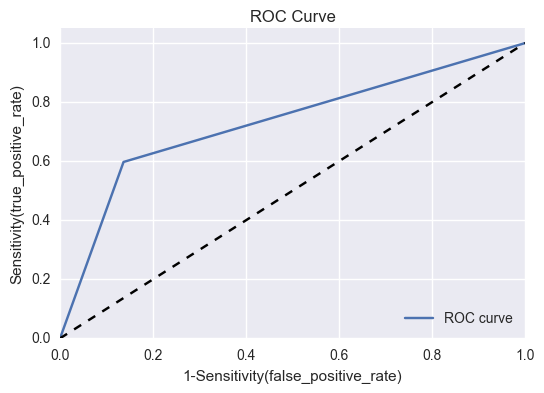

AUC(Area Under Curve): 
0.73040937344


C:\Users\pruth\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


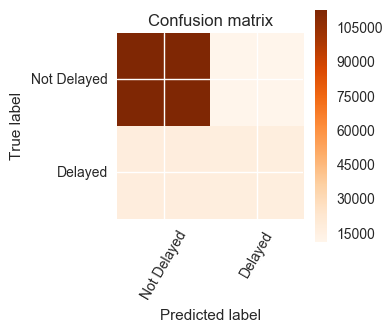

{'F1': [0.53824850182284745],
 'No_of_actual_delays': [35119],
 'No_of_delays_properly_classified': [17200],
 'No_of_nonDelays_improperly_classified_as_delys': [11592],
 'No_of_pred_delays': [28792],
 'No_of_records': [160000],
 'accuracy': [0.81555624999999998],
 'precision': [0.59738816337871636],
 'recall': [0.48976337595034025]}

In [49]:
azureMLrf(flights)

In [52]:
def azureMLknn(flights):
    min_delay = 15
    flights.dropna(subset=['CRSElapsedTime'], inplace=True)
    flights.dropna(subset=['DepDelay'], inplace=True)
    flights['CRSDepTimeinHr'] = flights['CRSDepTime']//100
    flights['CRSArrTimeinHr'] = flights['CRSArrTime']//100
    direction = 'Origin'
    col2 = 'DepDelay'
    if direction == 'Origin':
        col1 = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Dest','CRSElapsedTime','Distance']
    else:
        Xcols = ['Month','DayOfWeek','CRSDepTimeinHr','CRSArrTimeinHr','UniqueCarrier','Origin','CRSElapsedTime','Distance']

    X = flights[flights[direction] == 'ATL'][col1]
    Y = flights[flights[direction] == 'ATL'][col2]
    X['UniqueCarrier'] = pd.factorize(X['UniqueCarrier'])[0]

    if direction == 'Origin':
        X['Dest'] = pd.factorize(X['Dest'])[0]
    else:
        X['Origin'] = pd.factorize(X['Origin'])[0]

    # taking random values as our sampeled dataset
    random_rows = np.random.choice(X.index.values, 800000)
    random_X = X.ix[random_rows]
    random_Y = Y.ix[random_rows]

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(random_X, random_Y, test_size=0.20, random_state=0)
    
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(Xtrain, (np.where(Ytrain >= min_delay,1,0)))
    pre = knn.predict(Xtest)
    conf_mat = confusion_matrix(np.where(Ytest >= min_delay,1,0), pre)
    
    No_of_actual_delays = conf_mat[1][0] + conf_mat[1][1]
    No_of_pred_delays = conf_mat[0][1] + conf_mat[1][1]
    No_of_records = conf_mat[0][1] + conf_mat[1][1] + conf_mat[1][0] + conf_mat[0][0]
    No_of_delays_properly_classified = conf_mat[1][1]
    No_of_nonDelays_improperly_classified_as_delys = conf_mat[0][1]
    
    fprate, tprate, _ = metrics.roc_curve(pre, np.where(Ytest >= min_delay,1,0))

    plt.figure()
    plt.plot(fprate,tprate,label = 'ROC curve')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('1-Sensitivity(false_positive_rate)')
    plt.ylabel('Sensitivity(true_positive_rate)')
    plt.title('ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()
    
    print('AUC(Area Under Curve): ')
    print( metrics.auc(fprate, tprate))
    
#     print(pd.DataFrame(conf_mat))
    rf_report = precision_recall_fscore_support(list(np.where(Ytest >= min_delay,1,0)), list(pre), average='micro')

    show_confusion_matrix(conf_mat)

    d = {'precision': [rf_report[0]],'recall':[rf_report[1]],'F1':[rf_report[2]],'accuracy':[ accuracy_score(list(np.where(Ytest >= min_delay,1,0)), list(pre))]
        ,'No_of_actual_delays':[No_of_actual_delays],'No_of_pred_delays': [No_of_pred_delays], 'No_of_records': [No_of_records], 'No_of_delays_properly_classified': [No_of_delays_properly_classified]
        ,'No_of_nonDelays_improperly_classified_as_delys': [No_of_nonDelays_improperly_classified_as_delys]}
    df = pd.DataFrame(data=d)
    
    return df

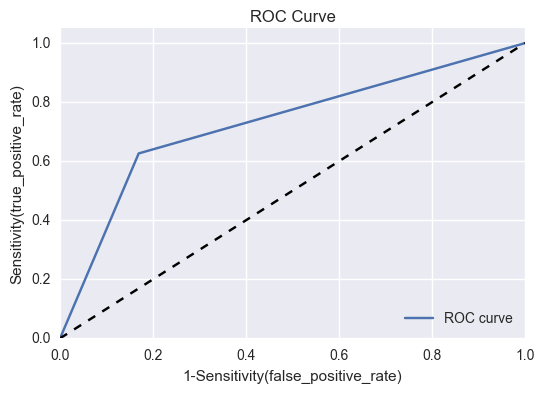

AUC(Area Under Curve): 
0.728575100483


C:\Users\pruth\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


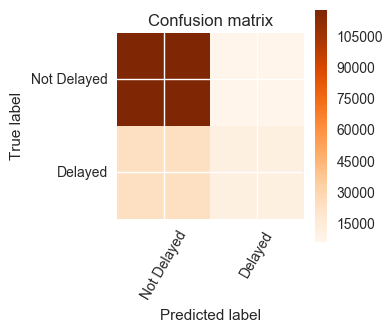

{'F1': [0.41673646539252263],
 'No_of_actual_delays': [35055],
 'No_of_delays_properly_classified': [10946],
 'No_of_nonDelays_improperly_classified_as_delys': [6531],
 'No_of_pred_delays': [17477],
 'No_of_records': [160000],
 'accuracy': [0.8085],
 'precision': [0.62630886307718714],
 'recall': [0.31225217515333048]}

In [53]:
azureMLknn(flights)

### The data is non linear in nature which means it wont be able to apply linear algorithms to classify the data the way we wish to make it classify, Also the data is highly unbalanced making it very tough to either do prediction or classification

### So We have to run tree based algorithms or SVM to achieve a good model, The problem with SVM is that it takes very long time and lot of computational power to train, We tried running it on IBM bluemix as well as local and kept it running for almost 2 days but were unable to achieve any success due to large amount of data alost 800,000 records, then we tried another approach of subsampling the data and making equal recoreds of non delayed and delayed and let it run for 6 hours but due to time constraints coul not go further, which leaves with only one option that is tree based algorithm to give us good models.

### As we can see the tree based Random Forests have turned out to be the best model giving us AUC(Area under curve ) of 0.73040937344 which otperforms other Logistic and KNN.

## Also, It is proven that Tree based algorithms are said to perform very well on the categprical dataset, which fits perfect for this case.

## The Random Forest model was highly successfull in predicting which flights were not delayed giving out more than 90% accuracy, and less successfull at predicting delayed flights of over 40% delayed flights correctly predicted.

